In [1]:
import os 
import numpy as np
import cv2 as cv
import re

In [2]:
path = 'E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/datasets/Multi-Weather Image Classification/dataset2/'

In [3]:
classes = {'cloudy':0, 'rain':1, 'shine':2, 'sunrise':3}

In [4]:
reg_exp = r'^[^0-9]*'

images = []
labels = []

def load_data(path):
    for files in os.listdir(path):
        label_req = re.findall(reg_exp, files)[0]
        label = classes[label_req]
        image = cv.imread(path + files)
        if image is None:
            continue
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, (150, 150))
        image = image.astype('float32')/255.0
        images.append(image)
        labels.append(label)
    images_r = np.array(images)
    labels_r = np.array(labels)
    return images_r, labels_r

In [5]:
images, labels = load_data(path)

In [6]:
images.shape, labels.shape

((1123, 150, 150, 3), (1123,))

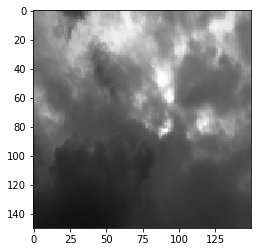

In [7]:
import matplotlib.pyplot as plt

plt.imshow(images[0])

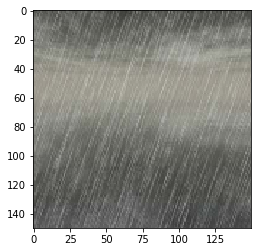

In [8]:
plt.imshow(images[300])

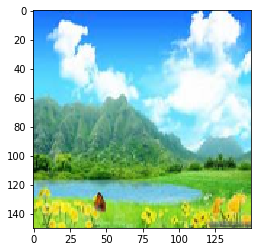

In [9]:
plt.imshow(images[600])

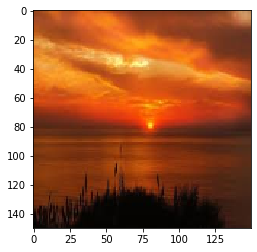

In [10]:
plt.imshow(images[1122])

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.05, random_state=10)

In [13]:
Y_train_req = to_categorical(Y_train)
Y_test_req = to_categorical(Y_test)

print(X_train.shape, X_test.shape, Y_train_req.shape, Y_test_req.shape)

(1066, 150, 150, 3) (57, 150, 150, 3) (1066, 4) (57, 4)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentor = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, validation_split=0.05)

train_batches = augmentor.flow(X_train, Y_train_req, shuffle=True, subset='training')
val_batches = augmentor.flow(X_train, Y_train_req, subset='validation')

In [15]:
del images
del labels

In [16]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:
def conv_layer(inputs, filters, stride):
    
    shortcut = inputs
    
    f1, f2, f3 = filters
    
    conv_a = Conv2D(f1, (1,1), strides=(stride,stride), kernel_initializer='he_normal')(inputs)
    conv_a = BatchNormalization(axis=3)(conv_a)
    conv_a = Activation('relu')(conv_a)
    
    conv_b = Conv2D(f2, (3,3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(conv_a)
    conv_b = BatchNormalization(axis=3)(conv_b)
    conv_b = Activation('relu')(conv_b)
    
    conv_c = Conv2D(f3, (1,1), strides=(1,1), kernel_initializer='he_normal')(conv_b)
    conv_c = BatchNormalization(axis=3)(conv_c)
    
    shortcut = Conv2D(f3, (1,1), strides=(stride, stride), kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization(axis=3)(shortcut)
    
    output = Add()([conv_c, shortcut])
    output = Activation('relu')(output)
    
    return output

In [18]:
def identity_layer(inputs, filters):
    
    shortcut = inputs
    
    f1, f2, f3 = filters
    
    conv_a = Conv2D(f1, (1,1), strides=(1,1), kernel_initializer='he_normal')(inputs)
    conv_a = BatchNormalization(axis=3)(conv_a)
    conv_a = Activation('relu')(conv_a)
    
    conv_b = Conv2D(f2, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(conv_a)
    conv_b = BatchNormalization(axis=3)(conv_b)
    conv_b = Activation('relu')(conv_b)
    
    conv_c = Conv2D(f3, (1,1), strides=(1,1), kernel_initializer='he_normal')(conv_b)
    conv_c = BatchNormalization(axis=3)(conv_c)
    
    output = Add()([conv_c, shortcut])
    output = Activation('relu')(output)
    
    return output

In [19]:
def ResNet50(input_shape, classes):
    
    inputs = Input(input_shape)
    
    zero_padding = ZeroPadding2D((3,3))(inputs)
    
    #### CONVOLUTION BLOCK 1
    conv_1 = Conv2D(64, (7,7), strides=(2,2), kernel_initializer='he_normal')(zero_padding)
    conv_1 = BatchNormalization(axis=3)(conv_1)
    conv_1 = Activation('relu')(conv_1)
    conv_1 = ZeroPadding2D((1,1))(conv_1)
    conv_1 = MaxPooling2D((3,3), strides=(2,2))(conv_1)
    
    #### CONVOLUTIONAL BLOCK 2
    conv_2 = conv_layer(conv_1, [64, 64, 256], stride=1)
    conv_2 = identity_layer(conv_2, [64,64,256])
    conv_2 = identity_layer(conv_2, [64, 64, 256])
    
    #### CONVOLUTIONAL BLOCK 3
    conv_3 = conv_layer(conv_2, [128, 128, 512], stride=2)
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    
    #### CONVOLUTIONAL BLOCK 4
    conv_4 = conv_layer(conv_3, [256, 256, 1024], stride=2)
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    
    #### CONVOLUTIONAL BLOCK 5
    conv_5 = conv_layer(conv_4, [512, 512, 2048], stride=2)
    conv_5 = identity_layer(conv_5, [512, 512, 2048])
    conv_5 = identity_layer(conv_5, [512, 512, 2048])
   
    #### AVERAGE POOLING
    avg_pooling = GlobalAveragePooling2D()(conv_5)
    
    output = Dense(classes, activation='softmax')(avg_pooling)
    
    model_resnet50 = Model(inputs=inputs, outputs=output)
    
    return model_resnet50

In [20]:
model = ResNet50(input_shape=(150,150,3), classes=4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 75, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 75, 75, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint(save_best_only=True, monitor='val_accuracy', patience=10, mode='max', filepath='E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/MultiClass Weather Classification/multiclass_weather_classification.h5')
es = EarlyStopping(patience=10, monitor='val_accuracy', mode='auto', restore_best_weights=True)

In [22]:
steps = 1013/8

history = model.fit_generator(train_batches, validation_data=val_batches, epochs=50, steps_per_epoch=steps, callbacks=[cp, es])

Epoch 1/50
127/126 [==============================] - 139s 1s/step - loss: 0.9508 - accuracy: 0.6498 - val_loss: 9.6168 - val_accuracy: 0.1698
Epoch 2/50
127/126 [==============================] - 620s 5s/step - loss: 0.4527 - accuracy: 0.8229 - val_loss: 0.8024 - val_accuracy: 0.6981
Epoch 3/50
127/126 [==============================] - 619s 5s/step - loss: 0.3202 - accuracy: 0.8786 - val_loss: 0.9676 - val_accuracy: 0.6981
Epoch 4/50
127/126 [==============================] - 620s 5s/step - loss: 0.2768 - accuracy: 0.8998 - val_loss: 0.6741 - val_accuracy: 0.7925
Epoch 5/50
127/126 [==============================] - 622s 5s/step - loss: 0.2335 - accuracy: 0.9137 - val_loss: 0.3647 - val_accuracy: 0.8679
Epoch 6/50
127/126 [==============================] - 620s 5s/step - loss: 0.2004 - accuracy: 0.9284 - val_loss: 0.8285 - val_accuracy: 0.7736
Epoch 7/50
127/126 [==============================] - 620s 5s/step - loss: 0.1885 - accuracy: 0.9326 - val_loss: 0.8853 - val_accuracy: 0.7736

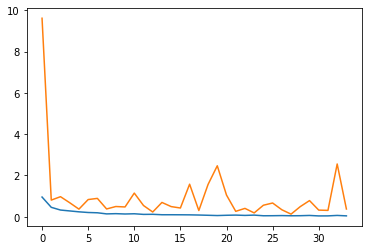

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

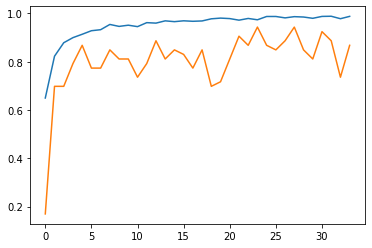

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [25]:
from tensorflow.keras.models import load_model

model_new = load_model('E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/MultiClass Weather Classification/multiclass_weather_classification.h5')

In [26]:
predictions = []

for i in range(len(X_test)):
    image = X_test[i].reshape((1, 150, 150, 3))
    predict = model_new.predict(image)
    i = np.argmax(predict)
    predictions.append(i)

In [27]:
predictions

[0,
 3,
 3,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 3,
 3,
 2,
 1,
 3,
 3,
 3,
 0,
 0,
 2,
 0,
 3,
 1,
 3,
 3,
 3,
 0,
 3,
 2,
 2,
 1,
 3,
 3,
 3,
 2,
 0,
 3,
 2,
 3,
 3,
 0,
 0,
 0,
 1,
 3,
 0,
 2,
 1,
 1,
 3,
 3]

0.9298245614035088


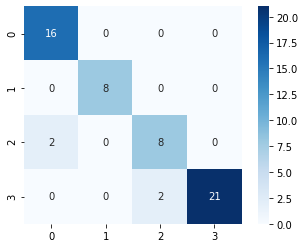

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

print(accuracy_score(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions)
hm = sns.heatmap(cm, annot=True, square=True, cmap='Blues')
plt.show()